In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
import os
import cv2
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

from tqdm import tqdm

import re
from IPython import display

BATCH_SIZE = 64

/home/yuan65536/.local/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
x_train = np.load('./dataset/x_train_imagenet_unlearn.npy')
y_train = np.load('./dataset/y_train_imagenet.npy')

x_val = np.load('./dataset/x_val_imagenet.npy')
y_val = np.load('./dataset/y_val_imagenet.npy')



x_test = np.load('./dataset/x_test_imagenet.npy')


y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

In [4]:
def rgb2gray(img_dir):
    res = []
    for i in range(len(img_dir)):
        img = img_dir[i]*255
        img = img.astype(np.uint8)
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray_img = gray_img/255
        res.append(gray_img)
        
    return np.asarray(res)

## Upsample and downsample

```preprocess的其中一個function，但是最後發現這個沒有甚麼作用```

In [5]:
def up_down_sample(img_dir):
    res=[]
    for i in range(len(img_dir)):
        img = img_dir[i]*255
        img = img.astype(np.uint8)
        [m, n] = img.shape
        f = 4
        img2 = np.zeros((m//f, n//f), dtype=np.int)


        for i in range(0, m, f):
            for j in range(0, n, f):
                try:

                    img2[i//f][j//f] = img[i][j]
                except IndexError:
                    pass

        # Create matrix of zeros to store the upsampled image
        img3 = np.zeros((m, n), dtype=np.int)
        # new size
        for i in range(0, m-1, f):
            for j in range(0, n-1, f):
                img3[i, j] = img2[i//f][j//f]

        # Replicating rows

        for i in range(1, m-(f-1), f):
            for j in range(0, n-(f-1)):
                img3[i:i+(f-1), j] = img3[i-1, j]

        for i in range(0, m-1):
            for j in range(1, n-1, f):
                img3[i, j:j+(f-1)] = img3[i, j-1]

                
        img3 = img3/255
        res.append(img3)
        
    return np.asarray(res)        

In [6]:
def dummy_rgb(gray):
    dummy_RGB_images = np.repeat(gray[..., np.newaxis], 3, -1)
    
    return dummy_RGB_images

In [7]:
x_train_gray=rgb2gray(x_train)
x_val_gray=rgb2gray(x_val)

x_test_gray=rgb2gray(x_test)

#x_train_gray=tf.expand_dims(x_train_gray, -1)
#x_val_gray=tf.expand_dims(x_val_gray, -1)

In [8]:
def Sobel(img):
    res=[]
    for i in range(len(img)):
        temp = img[i]*255
        x = cv2.Sobel(temp, cv2.CV_16S, 1, 0, ksize=5) 
        y = cv2.Sobel(temp, cv2.CV_16S, 0, 1, ksize=5)

        # 轉換為影像原本儲存的格式 uint8
        absX = cv2.convertScaleAbs(x) 
        absY = cv2.convertScaleAbs(y)

        # 將兩個軸向的測邊結果相加，形成完整輪廓
        dst = cv2.addWeighted(absX, 0.5, absX,0.5,0)        
        dst = dst/255
        res.append(dst)
        
        
    return np.asarray(res)


In [9]:
x_train_sobel = Sobel(x_train_gray)
x_val_sobel = Sobel(x_val_gray)
x_test_sobel = Sobel(x_test_gray)

In [17]:
x_updown_train = up_down_sample(x_train_gray)
x_updown_val = up_down_sample(x_val_gray)
x_updown_test = up_down_sample(x_test_gray)

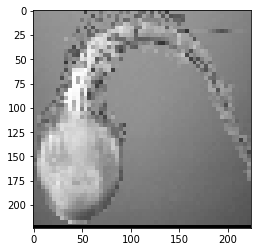

In [18]:
plt.imshow(x_updown_train[0],cmap='gray')

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_sobel, y_train))
train_dataset = train_dataset.shuffle(20)
batched_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val_sobel, y_val))
val_dataset = val_dataset.shuffle(20)
batched_val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

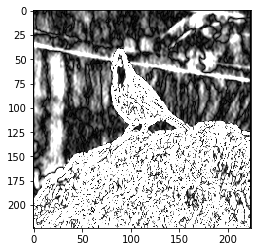

In [13]:
for data in batched_dataset.take(1):
    plt.imshow(data[0][3],cmap='gray')

In [10]:
from tensorflow.keras.applications import Xception
model = Xception(include_top=False,
                 weights = None,
                 input_tensor=layers.Input(shape=(224, 224, 1))
                 )

x = model.output
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512,activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dropout(0.7)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)
predictions = layers.Dense(2, activation='softmax')(x)
model = keras.Model(inputs=model.input, outputs=predictions)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [9]:
densenet = tf.keras.applications.densenet.DenseNet121(
    include_top=True, weights= None, input_tensor=None,
    input_shape=(224,224,1), pooling=None, classes=2
)

In [10]:
model = Sequential()

In [11]:
model.add(densenet)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.7))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(2))

In [12]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

In [13]:
checkpoint_filepath = './ckpt/checkpoint_Dense_{epoch}/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True
    )

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history=model.fit(x=batched_dataset, validation_data=batched_val_dataset, epochs=120, callbacks=[model_checkpoint_callback])


Epoch 1/120
34/34 [==============================] - 15s 436ms/step - loss: 0.9502 - acc: 0.5179 - val_loss: 0.6904 - val_acc: 0.5938
Epoch 2/120
34/34 [==============================] - 13s 385ms/step - loss: 0.7657 - acc: 0.6250 - val_loss: 0.6858 - val_acc: 0.5938
Epoch 3/120
34/34 [==============================] - 13s 385ms/step - loss: 0.5450 - acc: 0.7711 - val_loss: 0.6716 - val_acc: 0.5938
Epoch 4/120
34/34 [==============================] - 13s 386ms/step - loss: 0.4808 - acc: 0.8120 - val_loss: 0.6775 - val_acc: 0.5938
Epoch 5/120
34/34 [==============================] - 13s 385ms/step - loss: 0.3943 - acc: 0.8405 - val_loss: 0.7017 - val_acc: 0.4062
Epoch 6/120
34/34 [==============================] - 13s 385ms/step - loss: 0.3685 - acc: 0.8557 - val_loss: 0.7323 - val_acc: 0.4062
Epoch 7/120
34/34 [==============================] - 13s 386ms/step - loss: 0.3282 - acc: 0.8782 - val_loss: 0.7496 - val_acc: 0.4062
Epoch 8/120
34/34 [==============================] - 13s 386ms

Epoch 60/120
34/34 [==============================] - 13s 386ms/step - loss: 0.0254 - acc: 0.9940 - val_loss: 0.9581 - val_acc: 0.8156
Epoch 61/120
34/34 [==============================] - 13s 387ms/step - loss: 0.0288 - acc: 0.9894 - val_loss: 0.6402 - val_acc: 0.8375
Epoch 62/120
34/34 [==============================] - 13s 387ms/step - loss: 0.0456 - acc: 0.9848 - val_loss: 0.6204 - val_acc: 0.8375
Epoch 63/120
34/34 [==============================] - 13s 387ms/step - loss: 0.0272 - acc: 0.9922 - val_loss: 1.3694 - val_acc: 0.7594
Epoch 64/120
34/34 [==============================] - 13s 387ms/step - loss: 0.0389 - acc: 0.9881 - val_loss: 2.0521 - val_acc: 0.6375
Epoch 65/120
34/34 [==============================] - 13s 386ms/step - loss: 0.0508 - acc: 0.9848 - val_loss: 2.3684 - val_acc: 0.5344
Epoch 66/120
34/34 [==============================] - 13s 387ms/step - loss: 0.0332 - acc: 0.9885 - val_loss: 0.8196 - val_acc: 0.7844
Epoch 67/120
34/34 [==============================] - 1

In [14]:
model.load_weights(checkpoint_filepath.format(epoch=117))

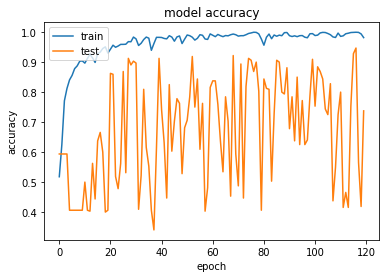

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Writing training dataset and output Test file

In [16]:
result = model.predict(x_test_sobel)
result = np.argmax(result,axis=1)

array = np.arange(0, 100, 1)


print((result.shape))
print(len(array))

(100,)
100


In [17]:
import pandas as pd


id_ = pd.DataFrame(array, columns=['id'])
label = pd.DataFrame(result,columns=['label'])


final = pd.concat([id_,label],axis=1)


final.head()
final.to_csv(r'result_x_Dense117.csv',index=False)


In [11]:
print(type(x_train_sobel))

<class 'numpy.ndarray'>


In [15]:
np.save('x_train_sobel', x_train_sobel)